In [1]:
!pip install clearml
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=SECRET_KEY
%env CLEARML_API_SECRET_KEY=SECRET_KEY
!git clone https://github.com/ardipazij/fruits_dataset.git
!rm -r /content/fruits_dataset/.git
!pip install rembg
!pip install efficientnet_pytorch
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.9 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0
env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=Z06HXDKZGZIQSYTXU4IF
env: CLEARML_API_SECRET_KEY=KnXWSZ2MMEOtAhOvEzsjG5xuu5zMbHOvNp9wzK76xnf3YMIEyx
Cloning into 'fruits_dataset'...
remote: Enumerating objects: 90644, done.
remote: Total 90644 (delta 0), reused 0 (delta 0), pack-reused 90644
Receiving objects: 100% (90644/90644), 384.48 MiB | 16.13 MiB/s, done.
Updating files: 100% (90381/90381), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [7]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from clearml import Task, Logger
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import time
import rembg
from efficientnet_pytorch import EfficientNet
import torchvision.models as models
import torch.nn as nn
from torchmetrics import Precision, Recall, F1Score
import torch.optim.lr_scheduler as lr_scheduler

In [8]:
task = Task.init(project_name="Fruit Classification kfu", task_name="EfficientNet_final_version_final_finaaaaaaal")
logger = task.get_logger()

epochs = 15
batch_size = 32
configuration_dict = {
    'number_of_epochs': epochs,
    'batch_size': batch_size,
    'base_lr': 1e-4,
    'weight_decay': 1e-4,
    'rescale_size': 64
}
configuration_dict = task.connect(configuration_dict)

In [9]:
data_dir = '/content/fruits_dataset'

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(os.path.join(data_dir, 'Training'), transform=train_transforms)
valid_data = datasets.ImageFolder(os.path.join(data_dir, 'Test'), transform=valid_transforms)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

In [5]:
class CustomShuffleNet(nn.Module):
    def __init__(self, num_classes=131):
        super(CustomShuffleNet, self).__init__()
        self.model = models.shufflenet_v2_x0_5(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [10]:
def validate(model, valid_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    precision_metric = Precision(num_classes=131, average='macro', dist_sync_on_step=False, task="multiclass").to(device)
    recall_metric = Recall(num_classes=131, average='macro', dist_sync_on_step=False, task="multiclass").to(device)
    f1_metric = F1Score(num_classes=131, average='macro', dist_sync_on_step=False, task="multiclass").to(device)

    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            precision_metric.update(preds, labels)
            recall_metric.update(preds, labels)
            f1_metric.update(preds, labels)

    val_loss /= len(valid_loader.dataset)
    accuracy = correct / total
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1 = f1_metric.compute().item()

    return val_loss, accuracy, precision, recall, f1

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    precision_metric = Precision(num_classes=131, average='macro', dist_sync_on_step=False, task="multiclass").to(device)
    recall_metric = Recall(num_classes=131, average='macro', dist_sync_on_step=False, task="multiclass").to(device)
    f1_metric = F1Score(num_classes=131, average='macro', dist_sync_on_step=False, task="multiclass").to(device)

    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        precision_metric.update(preds, labels)
        recall_metric.update(preds, labels)
        f1_metric.update(preds, labels)

    train_loss /= len(train_loader.dataset)
    accuracy = correct / total
    precision = precision_metric.compute().item()
    recall = recall_metric.compute().item()
    f1 = f1_metric.compute().item()

    return train_loss, accuracy, precision, recall, f1

def train_model(model, train_loader, valid_loader, criterion, optimizer, sheduler, device, num_epochs=10, checkpoint_dir='/content/drive/MyDrive/collab/fruits/logs'):

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    train_precisions, train_recalls, train_f1s = [], [], []
    val_precisions, val_recalls, val_f1s = [], [], []
    learning_rates = []

    for epoch in range(0, num_epochs):
        start_time = time.time()

        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        train_loss, train_accuracy, train_precision, train_recall, train_f1 = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate(model, valid_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)
        train_f1s.append(train_f1)

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        scheduler.step()

        end_time = time.time()

        task.get_logger().report_scalar("Loss", "Train", iteration=epoch, value=train_loss)
        task.get_logger().report_scalar("Accuracy", "Train", iteration=epoch, value=train_accuracy)
        task.get_logger().report_scalar("Precision", "Train", iteration=epoch, value=train_precision)
        task.get_logger().report_scalar("Recall", "Train", iteration=epoch, value=train_recall)
        task.get_logger().report_scalar("F1 Score", "Train", iteration=epoch, value=train_f1)
        task.get_logger().report_scalar("Learning Rate", "Train", iteration=epoch, value=current_lr)

        task.get_logger().report_scalar("Loss", "Validation", iteration=epoch, value=val_loss)
        task.get_logger().report_scalar("Accuracy", "Validation", iteration=epoch, value=val_accuracy)
        task.get_logger().report_scalar("Precision", "Validation", iteration=epoch, value=val_precision)
        task.get_logger().report_scalar("Recall", "Validation", iteration=epoch, value=val_recall)
        task.get_logger().report_scalar("F1 Score", "Validation", iteration=epoch, value=val_f1)

        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch
        }, os.path.join(checkpoint_dir, f'epoch_{epoch}.pth'))

        print(f'Train Loss: {train_loss:.4f} Acc: {train_accuracy:.4f} Precision: {train_precision:.4f} Recall: {train_recall:.4f} F1: {train_f1:.4f}')
        print(f'Validation Loss: {val_loss:.4f} Acc: {val_accuracy:.4f} Precision: {val_precision:.4f} Recall: {val_recall:.4f} F1: {val_f1:.4f}')
        print(f'Learning Rate: {current_lr:.6f}')
        print(f'Time: {(end_time - start_time):.2f}s')
        print()

    epochs = range(0, num_epochs)
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Epochs')

    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Epochs')

    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_precisions, label='Train Precision')
    plt.plot(epochs, val_precisions, label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('Precision vs Epochs')

    plt.subplot(2, 2, 4)
    plt.plot(epochs, learning_rates, label='Learning Rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.title('Learning Rate vs Epochs')

    plt.tight_layout()
    plt.show()


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Перед запуском тренировки модели следует создать папку на гугл
диске со следующим путем \
```
collab
----|fruits
----|----| logs
```

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X0_5_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth
100%|██████████| 5.28M/5.28M [00:00<00:00, 8.93MB/s]


2024-05-23 13:01:04,355 - clearml.model - INFO - Selected model id: 72aebf049b1f4e9ca19bcf04398d7956
Epoch 0/5
----------


2024-05-23 13:14:02,909 - clearml.frameworks - INFO - Found existing registered model id=29c3ce5c4e044f9dae7813aa2ac9d756 [/content/drive/MyDrive/collab/fruits/logs/epoch_0.pth] reusing it.
Train Loss: 2.7959 Acc: 0.4128 Precision: 0.5439 Recall: 0.3935 F1: 0.4024
Validation Loss: 0.8080 Acc: 0.8754 Precision: 0.8979 Recall: 0.8733 F1: 0.8678
Learning Rate: 0.000100
Time: 771.50s

Epoch 1/5
----------


2024-05-23 13:26:27,854 - clearml.frameworks - INFO - Found existing registered model id=a34bec0eb1ca4b16b8b63e5711107919 [/content/drive/MyDrive/collab/fruits/logs/epoch_1.pth] reusing it.
Train Loss: 0.8235 Acc: 0.8122 Precision: 0.8137 Recall: 0.8095 F1: 0.8088
Validation Loss: 0.2389 Acc: 0.9472 Precision: 0.9579 Recall: 0.9469 F1: 0.9449
Learning Rate: 0.000100
Time: 734.05s

Epoch 2/5
----------


2024-05-23 13:38:54,966 - clearml.frameworks - INFO - Found existing registered model id=f782e248a2cb44e6958502f22f084280 [/content/drive/MyDrive/collab/fruits/logs/epoch_2.pth] reusing it.
Train Loss: 0.4211 Acc: 0.8941 Precision: 0.8945 Recall: 0.8935 F1: 0.8935
Validation Loss: 0.1197 Acc: 0.9718 Precision: 0.9753 Recall: 0.9709 F1: 0.9706
Learning Rate: 0.000100
Time: 736.15s

Epoch 3/5
----------


2024-05-23 13:55:53,470 - clearml.frameworks - INFO - Found existing registered model id=42c1a1c5c4674772aef8f829a8da6eb4 [/content/drive/MyDrive/collab/fruits/logs/epoch_3.pth] reusing it.
Train Loss: 0.2857 Acc: 0.9243 Precision: 0.9244 Recall: 0.9237 F1: 0.9238
Validation Loss: 0.0972 Acc: 0.9722 Precision: 0.9767 Recall: 0.9709 F1: 0.9702
Learning Rate: 0.000100
Time: 1007.40s

Epoch 4/5
----------


2024-05-23 14:13:36,761 - clearml.frameworks - INFO - Found existing registered model id=a509e23355f648d2982feecb0fe79275 [/content/drive/MyDrive/collab/fruits/logs/epoch_4.pth] reusing it.
Train Loss: 0.2239 Acc: 0.9386 Precision: 0.9387 Recall: 0.9381 F1: 0.9383
Validation Loss: 0.0763 Acc: 0.9763 Precision: 0.9817 Recall: 0.9762 F1: 0.9760
Learning Rate: 0.000100
Time: 1052.14s

Epoch 5/5
----------


2024-05-23 14:28:16,638 - clearml.frameworks - INFO - Found existing registered model id=a559b22cfef84d4392dbad436ddc1f23 [/content/drive/MyDrive/collab/fruits/logs/epoch_5.pth] reusing it.
Train Loss: 0.1923 Acc: 0.9463 Precision: 0.9468 Recall: 0.9459 F1: 0.9462
Validation Loss: 0.0668 Acc: 0.9808 Precision: 0.9845 Recall: 0.9805 F1: 0.9805
Learning Rate: 0.000010
Time: 868.81s



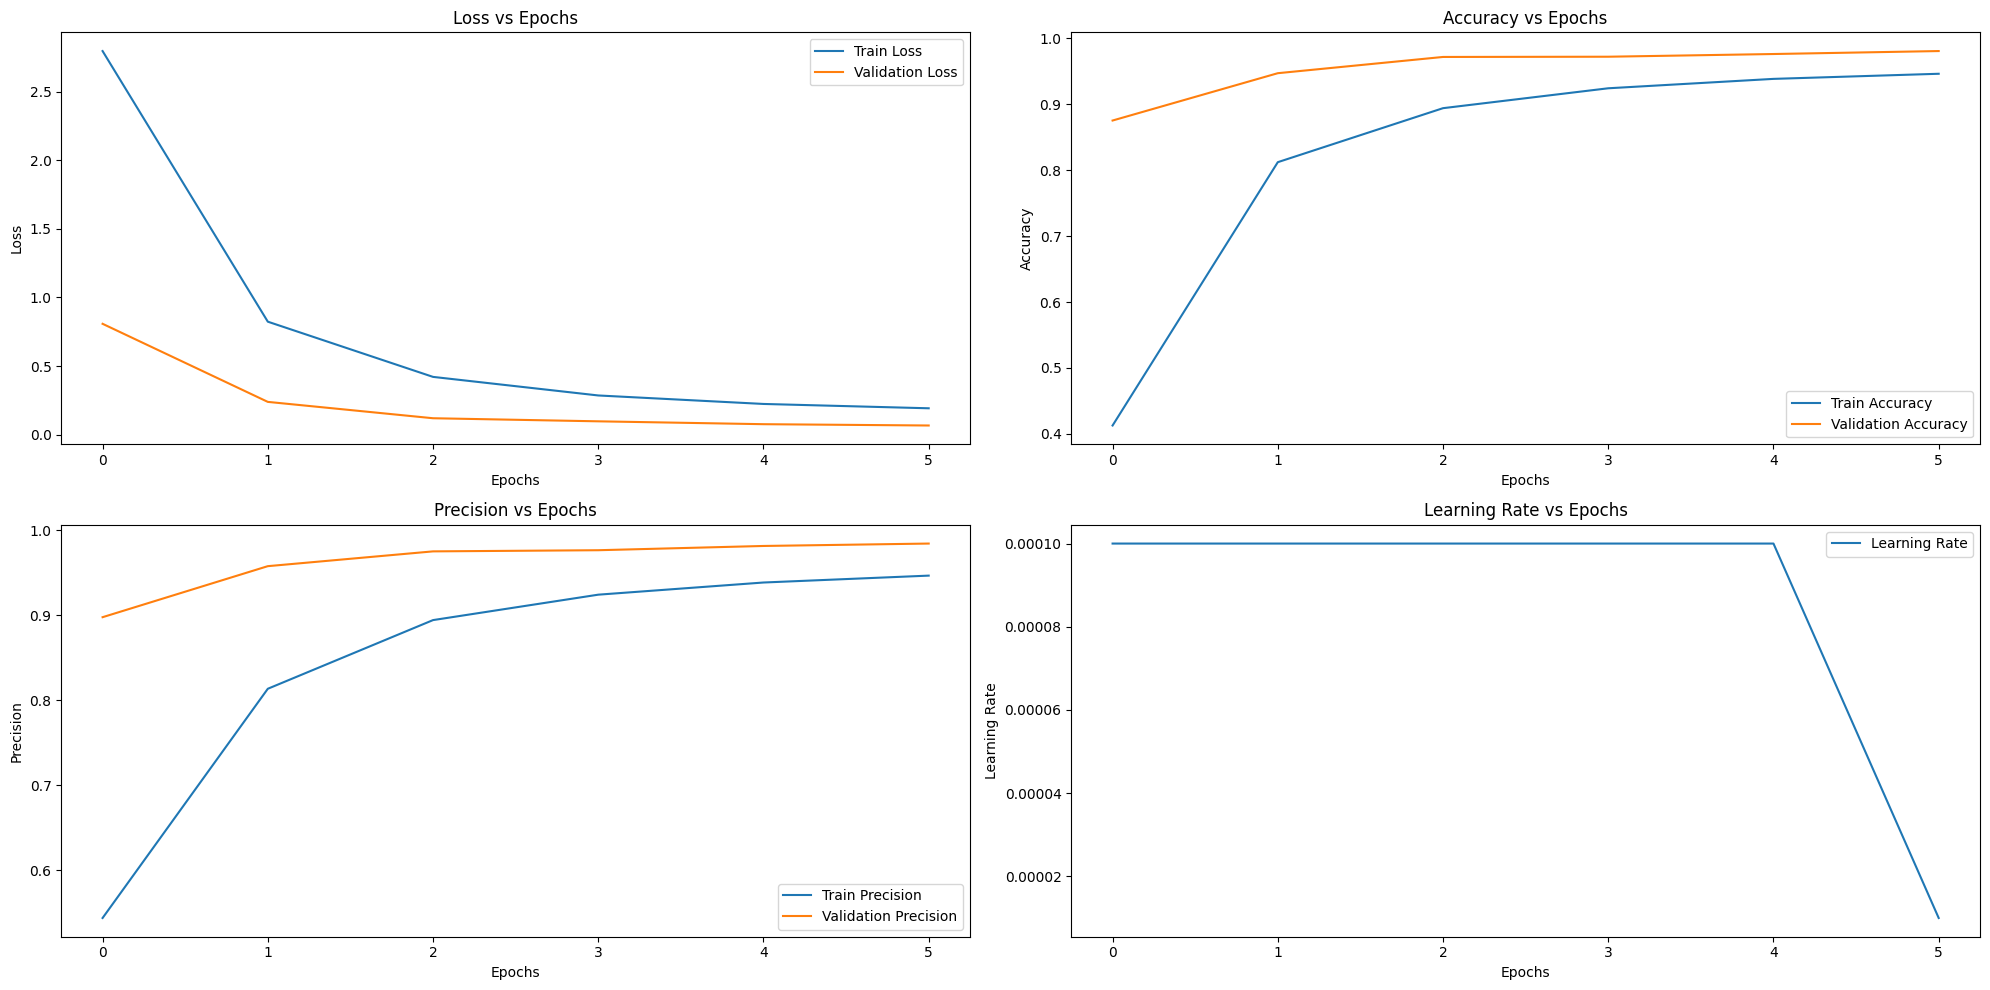

In [12]:
model = CustomShuffleNet(num_classes=131)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=configuration_dict['base_lr'], weight_decay=configuration_dict['weight_decay'])
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model.to(device)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, device, 6)